# Variational Classification Using Quantum Computers
### The variational quantum classifier is an algorithm where the measured expectation values for the outcomes of a parameterised quantum circuit are interpreted as outputs of a classifier. This quantum circuit is fed a set of variables, encoded in an appropriate way as a quantum mechanical state, from which we want to form a prediction, namely assigning the data point to a specific class. This algorithm comprises of two parts:
 - ### a quantum circuit which takes the encoded data as an input and outputs a quantum state
 - ### a classical circit which takes the measurement of the output quantum state, transforms it into classification probabilities, evaluates loss and cost functions, and uses these to update the parameters of the quantum circuit.
### We now consider a full implementation of such a binary classification algorithm.

In [141]:
# implement the data set on which we want to train the classifier
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 2024
total_iterations = 900

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
X_train, y_train, X_test, y_test = (ad_hoc_data(training_size=50, test_size=10, n=2, gap=0.3, one_hot=False))

### We have imported a toy data set which can be fully separated using the $\texttt{ZZFeatureMap}$ data encoding circuit. This is a high-dimensional angle encoder which generates entangled states. As the parameterised variational circuit we use the $\texttt{TwoLocal}$ circuit. We build the overall quantum circuit comprising of these two parts below.

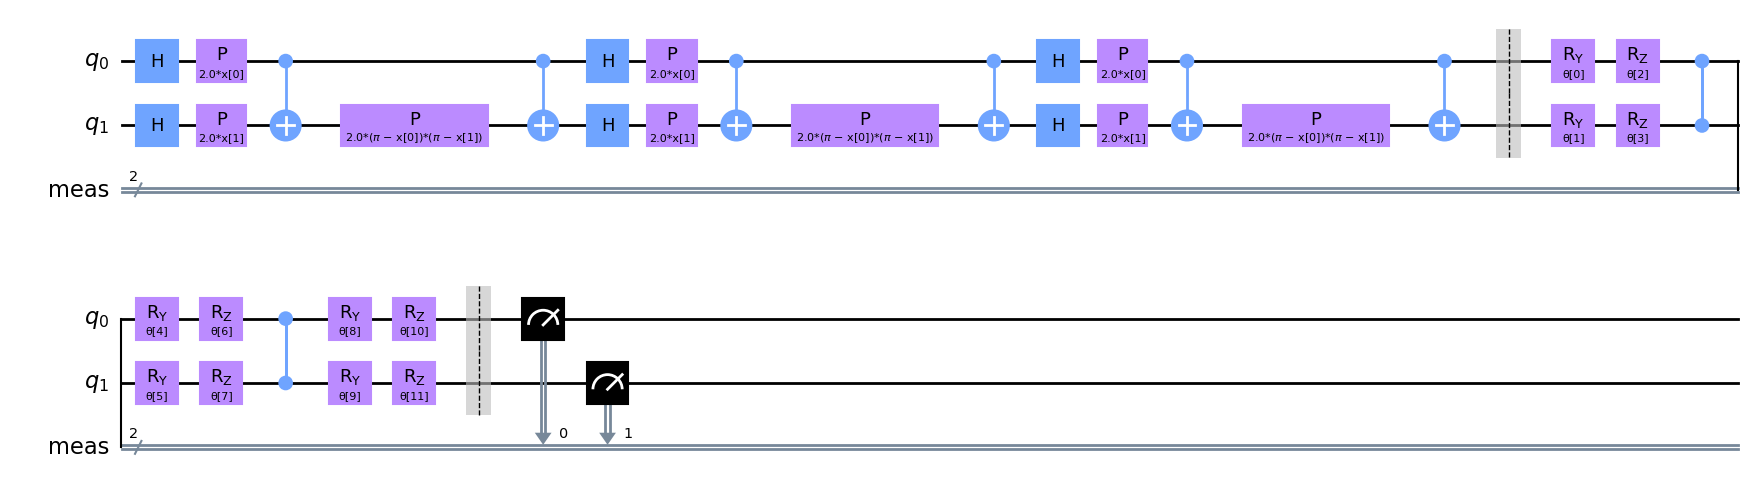

In [142]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
data_encoder = ZZFeatureMap(feature_dimension=2, reps=3)
variational_circuit = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

quantum_circuit = data_encoder.copy()
quantum_circuit.barrier()
quantum_circuit = quantum_circuit.compose(variational_circuit.copy())
quantum_circuit.measure_all()
quantum_circuit.decompose().draw(output='mpl')

In [143]:
# assign parameters to quantum circuit corresponding to input data point and variational parameters

def qc_instance(data_point, var_parameters):
    """
    Assign parameters to quantum circuit
    Args:
        data_point (list): Data values for encoder
        var_parameters (list): Parameters for current iteration of varitional circuit
    Returns:
        QuantumCircuit: quantum circuit component of algorithm with assigned parameters
    """
    parameters = {}
    for i, par in enumerate(data_encoder.ordered_parameters):
        parameters[par] = data_point[i]
    for i, par in enumerate(variational_circuit.ordered_parameters):
        parameters[par] = var_parameters[i]
    return quantum_circuit.assign_parameters(parameters=parameters)

### To determine the prediction from the output state of the quantum circuit, we calculate the Hamming weight of the output bit string. If it is even we assign the prediction to the class with label $1$, otherwise to the class with label $0$.

In [144]:
def prediction_from_state(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1)%2

### We will run the quantum circuit multiple times per iteration. For each iteration we will determine the prediction for the chosen data point, and measure the fraction of runs each of the classes has been predicted.

In [145]:
def class_probabilities(results):
    no_runs = sum(results.values())
    probabilities = {
        0 : 0,
        1 : 0
    }
    for bitstring, counts in results.items():
        class_pred = prediction_from_state(bitstring)
        probabilities[class_pred] += counts
    probabilities[0] /= no_runs
    probabilities[1] /= no_runs
    return probabilities

### We now define a circuit which runs the quantum circuit for each of the data points in the training set, and records the prediction probabilities.

In [146]:
from qiskit import BasicAer, execute

def run_quantum_circuit(data, var_parameters):
    """
    Classify all data points using passed parameters.
    Args:
        data (list): Set of test data points
        var_parameters (list): parameters for current iteraion of variational circuit
    Returns:
        list[dict]: Probabilities of circuit classifying each data point as 0 or 1
    """
    circuits = [qc_instance(data_point, var_parameters) for data_point in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classifications = [class_probabilities(results.get_counts(qc_instance)) for qc_instance in circuits]
    return classifications

### Once we have run the quantum part of out algorithm for each data point, we can calculate the cost and loss functions using the classification results.

In [155]:
def loss_function(classification, y_data):
    """
    Calculate accuracy of prediction for a single data point using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    prob_correct = classification[y_data]
    prob_correct += 1e-10 # add small quantity so that logarithm is calculable
    return -np.log(prob_correct) * y_data

def cost_function(X_data, y_data, var_parameters):
    """
    Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        X_data (list): List of data points to classify
        y_data (list): List of correct labels for each data point
        var_parameters (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = run_quantum_circuit(X_data, var_parameters)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += loss_function(classification, y_data[i])

    cost /= len(y_data)
    return cost

### We now define the classical optimiser using Simultaneous Perturbation Stochastic Approximation (SPSA). This is a gradient descent algorithm which chooses a random direction in paramter space in which to claculate the gradient and move along. This greatly reduces the number of calculation which must be performed compared to vanilla gradient descent, at the cost of non-smooth convergence. Nonetheless, the algorithm is still very likely to converge. The good thing about SPSA is that the operations performed per iteration is constant, rather than linear, w.r.t. the number of parameters.

Initial parameters: [0.2752686  0.46328458 0.76742228 0.82353519 0.03636899 0.58750739
 0.2259338  0.36679187 0.97594814 0.15737598 0.36552538 0.9259659 ]


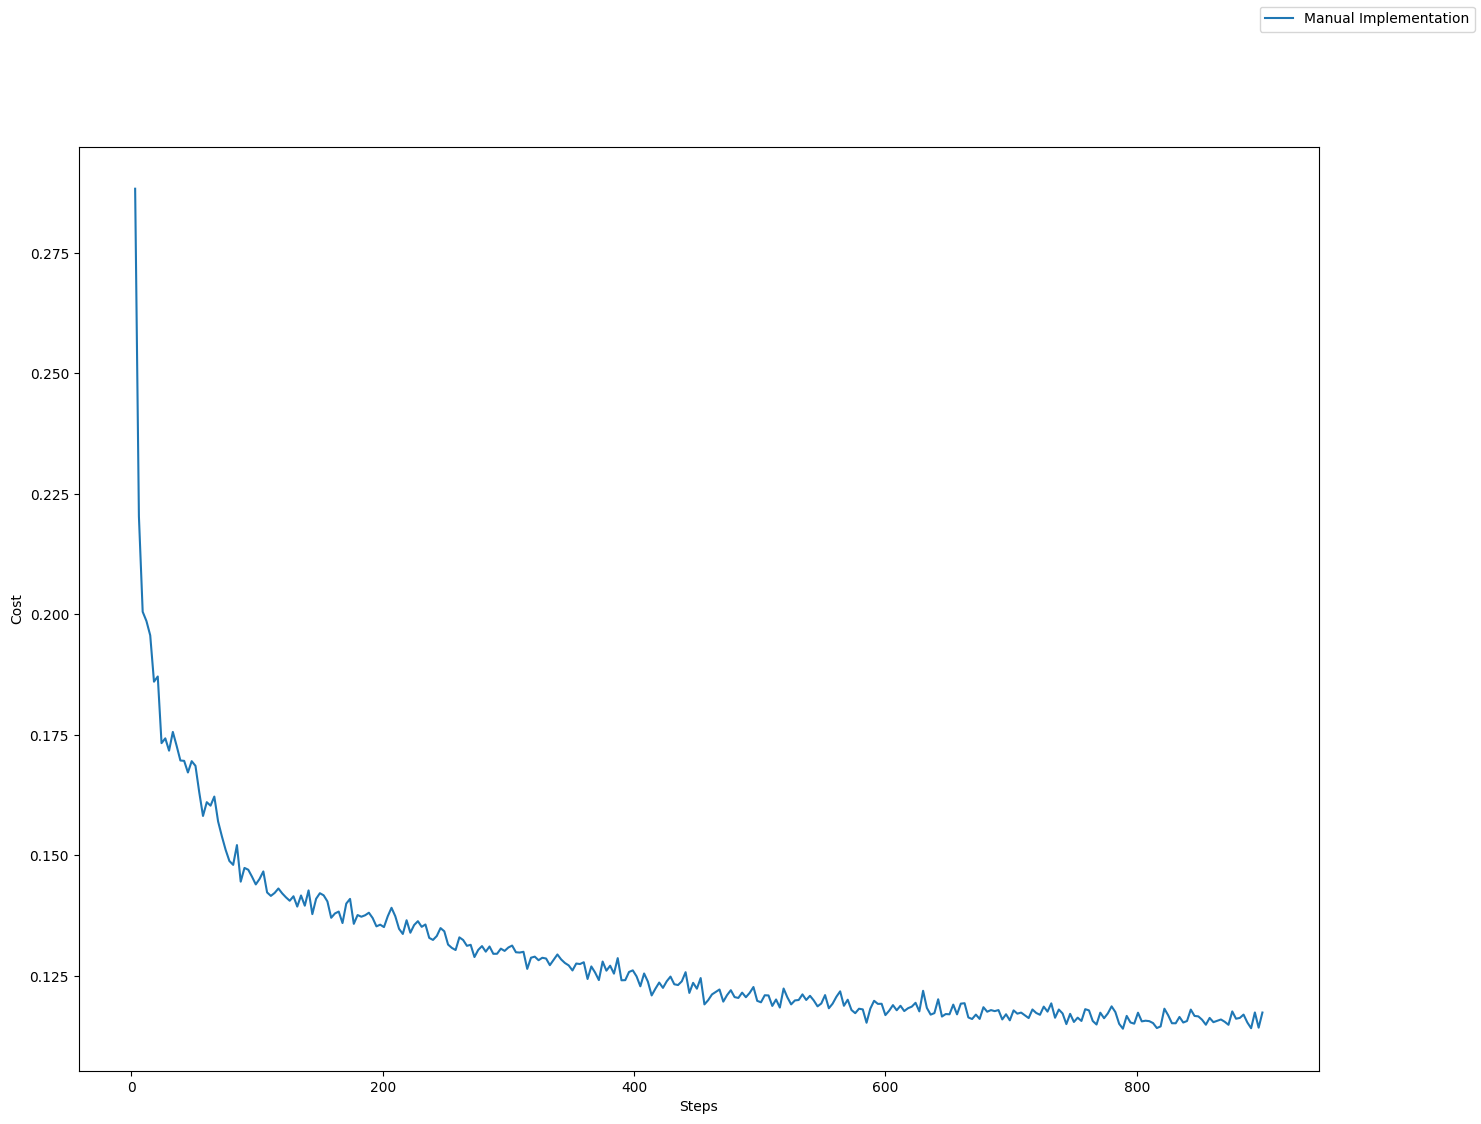

In [156]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=total_iterations//3, callback=log.update)

initial_point = np.random.random(variational_circuit.num_parameters)
print("Initial parameters:", initial_point)

def objective_function(var_parameters):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(X_train, y_train, var_parameters)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig_convergence, ax_convergence = plt.subplots(figsize = (16, 12))
ax_convergence.plot(log.evaluations, log.costs, label = "Manual Implementation")
ax_convergence.set_xlabel('Steps')
ax_convergence.set_ylabel('Cost')
fig_convergence.legend()

### We can now test the fitted classifier on the test data.

In [157]:
def test_classifier(X_data, y_data, var_parameters):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        X_data (list): List of data points to classify
        y_data (list): List of correct labels for each data point
        var_parameters (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `X_data`
        list: Classifier's label predictions for each data point
    """
    probabilities = run_quantum_circuit(X_data, var_parameters)
    predictions = [0 if p[0] > p[1] else 1 for p in probabilities] # threshold for classifier is 0.5
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == y_data[i]:
            accuracy += 1
    accuracy /= len(y_data)
    return accuracy, predictions

acc, predictions = test_classifier(X_test, y_test, opt_var)
print("Accuracy of manual implementation:", acc)

Accuracy of manual implementation: 0.65


### We can also try out the built-in qiskit version of the algorithm instead.

In [158]:
# need to one-hot encode the y_data first
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()


In [159]:
from qiskit_machine_learning.algorithms.classifiers import VQC
log_qiskit = OptimizerLog()
print("Initial parameters:", initial_point)
vqc = VQC(feature_map=data_encoder, ansatz=variational_circuit, loss='cross_entropy', optimizer=SPSA(callback=log_qiskit.update, maxiter=total_iterations//3), initial_point=initial_point, quantum_instance=BasicAer.get_backend('qasm_simulator'))
vqc.fit(X_train, y_train_oh)

Initial parameters: [0.2752686  0.46328458 0.76742228 0.82353519 0.03636899 0.58750739
 0.2259338  0.36679187 0.97594814 0.15737598 0.36552538 0.9259659 ]


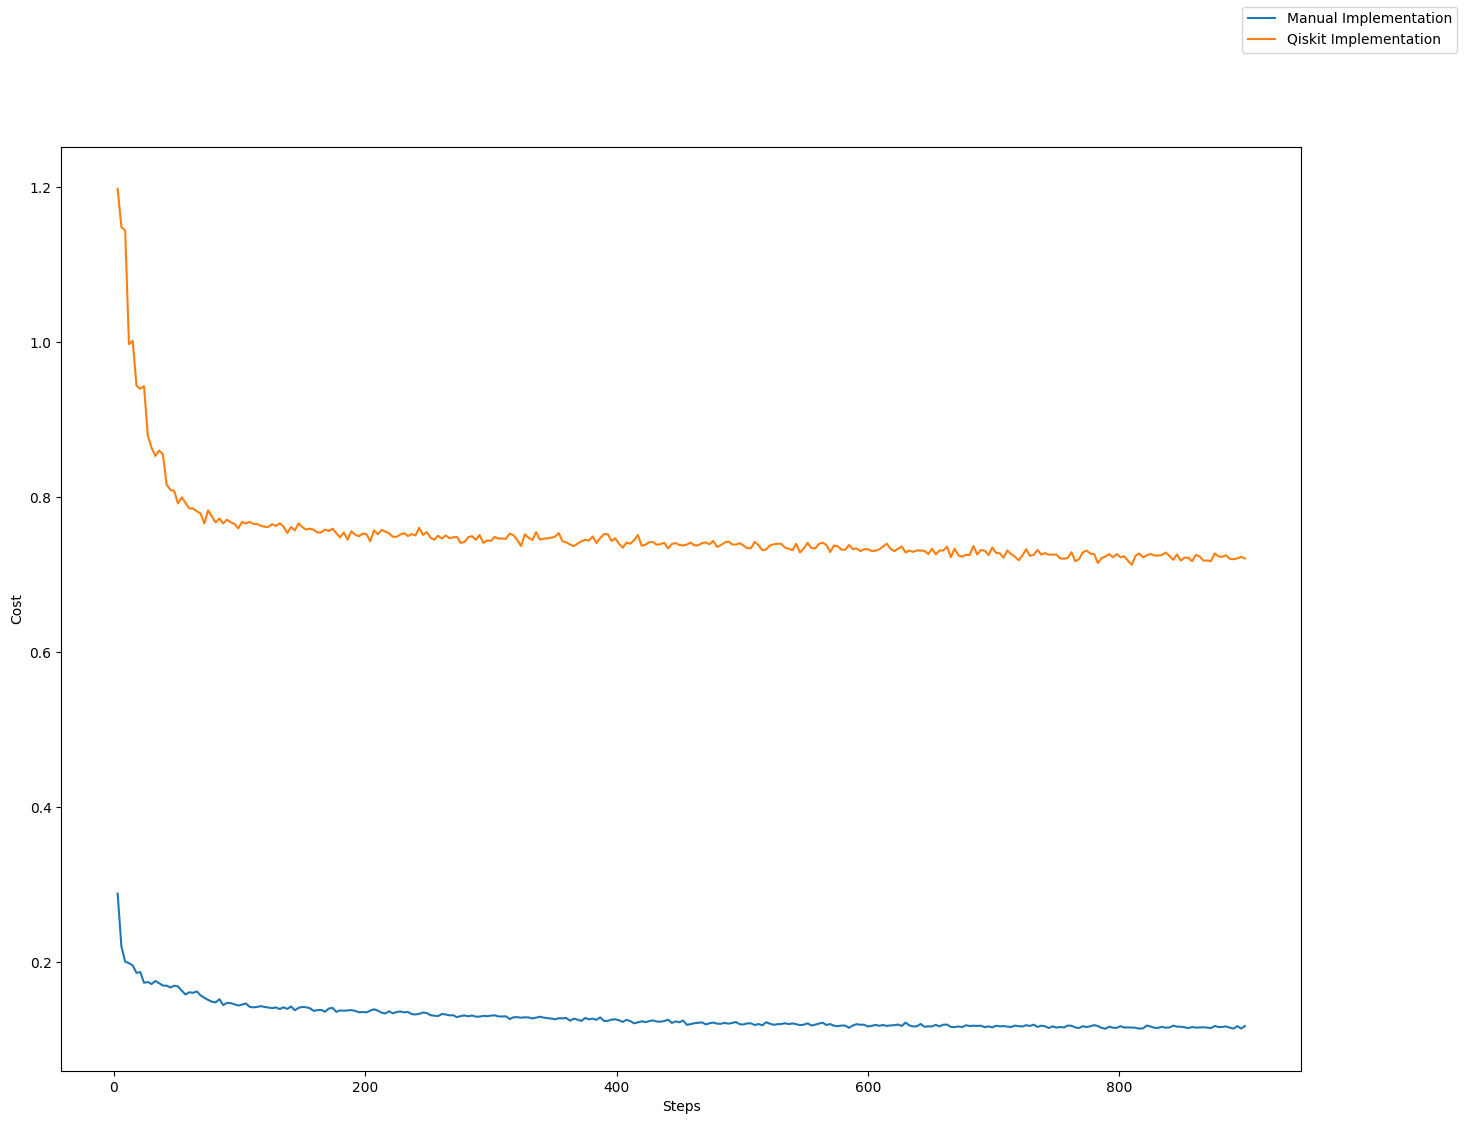

In [160]:
fig_convergence, ax_convergence = plt.subplots(figsize = (16, 12))
ax_convergence.plot(log.evaluations, log.costs, label = "Manual Implementation")
ax_convergence.plot(log_qiskit.evaluations, log_qiskit.costs, label = "Qiskit Implementation")
ax_convergence.set_xlabel('Steps')
ax_convergence.set_ylabel('Cost')
fig_convergence.legend()

In [161]:
print("Qiksit implementation:", vqc.score(X_test, y_test_oh))
y_test_predict = vqc.predict(X_test)[:, 1]

Qiksit implementation: 0.75


### We plot the training and test data on a scatter plot and mark the incorrectly classified points.

Text(0, 0.5, 'y')

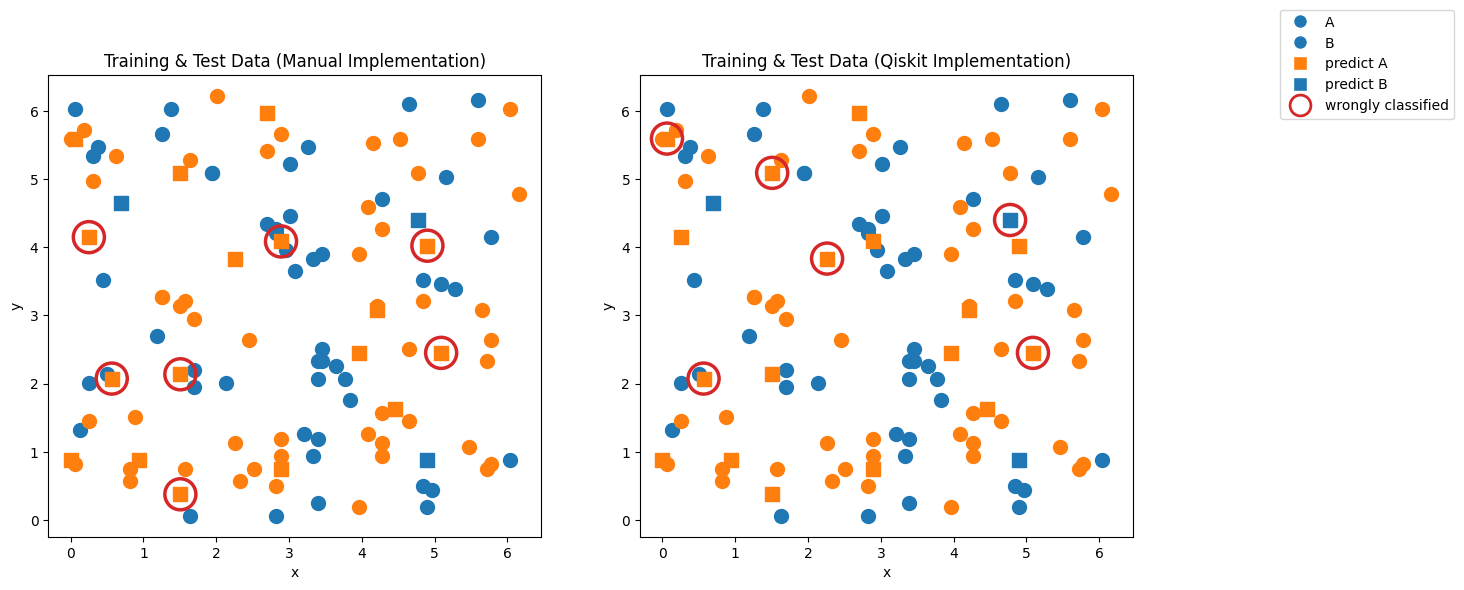

In [162]:
from matplotlib.lines import Line2D
fig_data, (ax_data_1, ax_data_2) = plt.subplots(1, 2, figsize = (14, 6))
# plt.figure(figsize=(9, 6))

for data_point, label in zip(X_train, y_train):
       COLOR = 'C0' if label == 0 else 'C1'
       ax_data_1.scatter(data_point[0], data_point[1],
                marker='o', s=100, color=COLOR)
       ax_data_2.scatter(data_point[0], data_point[1],
                marker='o', s=100, color=COLOR)

for data_point, label, prediction, prediction_qiskit in zip(X_test, y_test, predictions, y_test_predict):
       COLOR = 'C0' if prediction == 0 else 'C1'
       ax_data_1.scatter(data_point[0], data_point[1],
              marker='s', s=100, color=COLOR)
       if label != prediction:  # mark wrongly classified
              ax_data_1.scatter(data_point[0], data_point[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')
       ax_data_2.scatter(data_point[0], data_point[1],
              marker='s', s=100, color=COLOR)
       if label != prediction_qiskit:  # mark wrongly classified
              ax_data_2.scatter(data_point[0], data_point[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

fig_data.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

ax_data_1.set_title('Training & Test Data (Manual Implementation)')
ax_data_1.set_xlabel('x')
ax_data_1.set_ylabel('y')
ax_data_2.set_title('Training & Test Data (Qiskit Implementation)')
ax_data_2.set_xlabel('x')
ax_data_2.set_ylabel('y')

### We see that there is a slight improvement with the qiskit implementation over the manual one.